In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from skimage.metrics import structural_similarity as ssim

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

n_samples = 2000
test_samples = 200

# load the training and test datasets
X_train = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
X_test = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                    np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

idx = np.append(np.where(X_test.targets == 0)[0][:test_samples], 
                    np.where(X_test.targets == 1)[0][:test_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]
# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 1

# prepare data loaders
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [2]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.leaky_relu(self.t_conv1(x))
        x = F.leaky_relu(self.t_conv2(x))
        x = F.leaky_relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x

In [3]:
import matplotlib.pyplot as plt

def add_gaussian_noise(images, sigma=0.9):
	return torch.clamp(torch.distributions.Normal(0, sigma).sample(images.shape) + images, 0., 1.)

device = torch.device("cpu")
print(f'Selected device: {device}')


# initialize the NN
model = ConvDenoiser().to(device)
print(model)


# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Selected device: cpu
ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [4]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# number of epochs to train the model
n_epochs = 50

# for adding noise to images
noise_factor=0.5

losses = []
psnrs = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        # add noise to the original images
        noisy_imgs = add_gaussian_noise(images)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs.to(device))
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images.to(device))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

        batch_avg_psnr = 0.0
        outputs = outputs.detach().view(len(images), 1, 28, 28)
        for i in range(len(images)):
            org = np.transpose(images[i], (1, 2, 0)).detach().numpy()
            denoise = np.transpose(outputs[i], (1, 2, 0)).detach().numpy()
            batch_avg_psnr += psnr(org, denoise)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)

    losses.append(train_loss)
    psnrs.append(batch_avg_psnr)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
    ))

# losses = np.array(losses)
# to csv
# np.savetxt('classical_losses.csv', losses, delimiter=',')

# psnrs = np.array(psnrs)
# to csv
# np.savetxt('classical_psnrs.csv', psnrs, delimiter=',')

Epoch: 1 	Training Loss: 0.035085
Epoch: 2 	Training Loss: 0.026808
Epoch: 3 	Training Loss: 0.025218
Epoch: 4 	Training Loss: 0.024588
Epoch: 5 	Training Loss: 0.024097
Epoch: 6 	Training Loss: 0.023860
Epoch: 7 	Training Loss: 0.023381
Epoch: 8 	Training Loss: 0.023286
Epoch: 9 	Training Loss: 0.023160
Epoch: 10 	Training Loss: 0.022884
Epoch: 11 	Training Loss: 0.022726
Epoch: 12 	Training Loss: 0.022703
Epoch: 13 	Training Loss: 0.022478
Epoch: 14 	Training Loss: 0.022408
Epoch: 15 	Training Loss: 0.022460
Epoch: 16 	Training Loss: 0.022275
Epoch: 17 	Training Loss: 0.022169
Epoch: 18 	Training Loss: 0.022053
Epoch: 19 	Training Loss: 0.022052
Epoch: 20 	Training Loss: 0.022011
Epoch: 21 	Training Loss: 0.022043
Epoch: 22 	Training Loss: 0.021944
Epoch: 23 	Training Loss: 0.021785
Epoch: 24 	Training Loss: 0.021890
Epoch: 25 	Training Loss: 0.021774
Epoch: 26 	Training Loss: 0.021653
Epoch: 27 	Training Loss: 0.021534
Epoch: 28 	Training Loss: 0.021717
Epoch: 29 	Training Loss: 0.0

In [6]:
# ncols = 10
# fig, axes = plt.subplots(nrows=3, ncols=ncols, sharex=True, sharey=True, figsize=(25,7))

# with torch.no_grad():
#     for k in range(ncols):
#         dataiter = iter(test_loader)
#         images, labels = next(dataiter)
#         noisy_imgs = add_gaussian_noise(images, sigma=0.25)
#         output = model(noisy_imgs.to(device)).to(device)
#         noisy_imgs = noisy_imgs.numpy()
#         output = output.view(1, 1, 28, 28)
#         output = output.cpu().detach().numpy()
#         col_axes = axes[:, k]
#         col_axes[0].imshow(np.squeeze(images), cmap='gist_gray')
#         col_axes[1].imshow(np.squeeze(noisy_imgs), cmap='gist_gray')
#         col_axes[2].imshow(np.squeeze(output), cmap='gist_gray')

#     plt.savefig('classical_denoising.png')

In [7]:
# from skimage.metrics import peak_signal_noise_ratio as psnr

# avg_psnr = 0
# test_size = 0

# for data in test_loader:
#     images = data[0]
#     noisy_imgs = add_gaussian_noise(images)
#     output = model(noisy_imgs)
#     output = output.view(len(images), 1, 28, 28)
#     output = output.detach().cpu()
#     batch_avg_psnr = 0
#     for i in range(len(images)):
#         org = np.transpose(images[i], (1, 2, 0)).numpy()
#         denoise = np.transpose(output[i], (1, 2, 0)).numpy()
#         batch_avg_psnr += psnr(org, denoise)
#     avg_psnr += batch_avg_psnr
#     test_size += len(images)
# print(
#     "On Test data of {} examples:\nAverage PSNR: {:.3f}".format(
#         test_size, avg_psnr / test_size
#     )
# )

In [5]:
from skimage.metrics import structural_similarity as ssim

0.8269261543144479


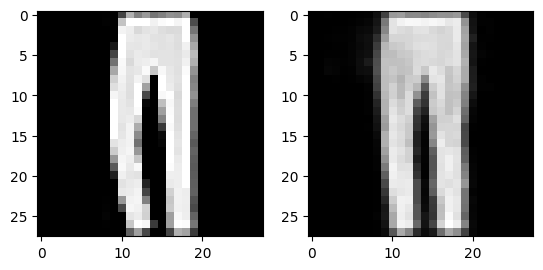

In [13]:
for data in test_loader:
    images = data[0]
    noisy_imgs = add_gaussian_noise(images, sigma=1)
    output = model(noisy_imgs)
    output = output.view(len(images), 1, 28, 28)
    output = output.detach().cpu()
    # for i in range(len(images)):
    #     org = images[i].numpy().squeeze()
    #     denoise = output[i].numpy().squeeze()
    #     ssim_val = ssim(org, denoise, full=True, data_range=data_range)
    images = images.numpy().squeeze()
    output = output.numpy().squeeze()
    ssim_val = ssim(images, output, data_range=1.0)

    plt.subplot(1, 2, 1)
    plt.imshow(images, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(output, cmap='gray')
print(ssim_val)